# Surface Water Exploration\n
\n
This notebook explores the JRC Global Surface Water dataset for the Black Hills region, analyzing water extent and persistence from 2013 to 2021.

In [ ]:
import os
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import seaborn as sns
from glob import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import stats as scipy_stats

# Set plot style
plt.style.use('default')
sns.set_palette("Blues_r")

## Load Surface Water Data\n\n
Load all yearly surface water GeoTIFF files from the EarthEngine_SurfaceWater directory.

In [2]:
# Path to surface water data
water_path = "../data/EarthEngine_SurfaceWater/"

# Get all surface water files
water_files = sorted(glob(os.path.join(water_path, "*.tif")))
print(f"Found {len(water_files)} surface water files")

# Extract years from filenames
years = []
for f in water_files:
    year = int(os.path.basename(f).split('_')[-1].split('.')[0])
    years.append(year)
    
print(f"Years available: {min(years)} to {max(years)}")

Found 9 surface water files
Years available: 2013 to 2021


In [3]:
# Load all surface water data into a dictionary
water_data = {}
for file, year in zip(water_files, years):
    try:
        data = rxr.open_rasterio(file, masked=True).squeeze()
        water_data[year] = data
        print(f"Loaded {year}: shape {data.shape}, CRS: {data.rio.crs}")
    except Exception as e:
        print(f"Error loading {year}: {e}")

# Get reference data for spatial information
ref_data = list(water_data.values())[0]
print(f"\nSpatial extent: {ref_data.rio.bounds()}")
print(f"Resolution: {ref_data.rio.resolution()}")

Loaded 2013: shape (4358, 5348), CRS: EPSG:4326
Loaded 2014: shape (4358, 5348), CRS: EPSG:4326
Loaded 2015: shape (4358, 5348), CRS: EPSG:4326
Loaded 2016: shape (4358, 5348), CRS: EPSG:4326
Loaded 2017: shape (4358, 5348), CRS: EPSG:4326
Loaded 2018: shape (4358, 5348), CRS: EPSG:4326
Loaded 2019: shape (4358, 5348), CRS: EPSG:4326
Loaded 2020: shape (4358, 5348), CRS: EPSG:4326
Loaded 2021: shape (4358, 5348), CRS: EPSG:4326

Spatial extent: (-104.70511423417591, 43.47998688736784, -103.26385719233454, 44.65444428982571)
Resolution: (0.0002694945852358564, -0.0002694945852358564)


## Calculate Annual Water Extent
Calculate the total water extent for each year.

In [ ]:
# Calculate annual water extent statistics
annual_stats = []

for year, data in water_data.items():
    # Count water pixels (assuming water areas have value > 0)
    water_pixels = (data > 0).sum().values
    
    # Calculate area - data is in geographic coordinates (degrees)
    # Convert degrees to approximate area using Earth radius
    lat_res_deg = abs(data.rio.resolution()[1])  # degrees
    lon_res_deg = abs(data.rio.resolution()[0])  # degrees
    
    # Get center latitude for area calculation
    center_lat = (data.y.min() + data.y.max()) / 2
    lat_rad = np.radians(center_lat.values)
    
    # Convert to meters at center latitude
    deg_to_m_lat = 111320  # meters per degree latitude
    deg_to_m_lon = 111320 * np.cos(lat_rad)  # meters per degree longitude at this latitude
    
    pixel_area_m2 = lat_res_deg * deg_to_m_lat * lon_res_deg * deg_to_m_lon
    water_area_m2 = water_pixels * pixel_area_m2
    
    # Convert to hectares and square kilometers
    water_area_ha = water_area_m2 / 10000
    water_area_km2 = water_area_m2 / 1000000
    
    annual_stats.append({
        'year': year,
        'water_pixels': int(water_pixels),
        'water_area_ha': float(water_area_ha),
        'water_area_km2': float(water_area_km2)
    })

# Create DataFrame
stats_df = pd.DataFrame(annual_stats)
stats_df = stats_df.sort_values('year')

# Display summary statistics
print("Annual Surface Water Statistics:")
print(stats_df.round(2).to_string(index=False))

# Find years with most/least water
print(f"\nYear with maximum water extent: {stats_df.loc[stats_df['water_area_km2'].idxmax(), 'year']} "
      f"({stats_df['water_area_km2'].max():.2f} km²)")
print(f"Year with minimum water extent: {stats_df.loc[stats_df['water_area_km2'].idxmin(), 'year']} "
      f"({stats_df['water_area_km2'].min():.2f} km²)")
print(f"Average annual water extent: {stats_df['water_area_km2'].mean():.2f} km²")

## Visualize Annual Water Extent Time Series

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

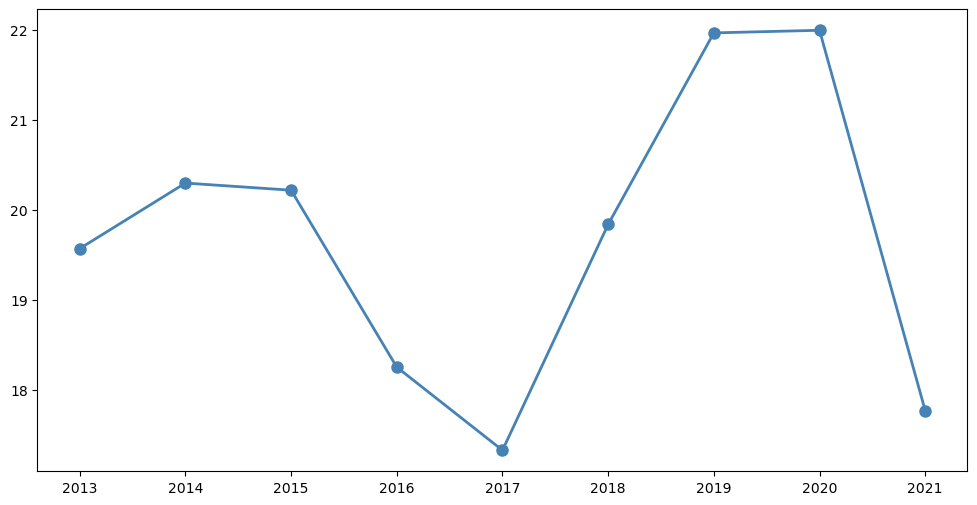

In [5]:
# Create time series plot
fig, ax = plt.subplots(figsize=(12, 6))

# Line plot with markers
ax.plot(stats_df['year'], stats_df['water_area_km2'], 
        marker='o', markersize=8, linewidth=2, color='steelblue')

# Fill area under curve
ax.fill_between(stats_df['year'], stats_df['water_area_km2'], 
                alpha=0.3, color='lightblue')

# Add mean line
ax.axhline(y=stats_df['water_area_km2'].mean(), color='darkblue', 
           linestyle='--', alpha=0.7, label=f"Mean: {stats_df['water_area_km2'].mean():.2f} km²")

# Highlight max and min years
max_year = stats_df.loc[stats_df['water_area_km2'].idxmax()]
min_year = stats_df.loc[stats_df['water_area_km2'].idxmin()]

ax.scatter(max_year['year'], max_year['water_area_km2'], 
          color='darkgreen', s=100, zorder=5, label=f"Max: {max_year['year']}")
ax.scatter(min_year['year'], min_year['water_area_km2'], 
          color='darkred', s=100, zorder=5, label=f"Min: {min_year['year']}")

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Water Extent (km²)', fontsize=12)
ax.set_title('Annual Surface Water Extent in the Black Hills Region (2013-2021)', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Set y-axis to start from 0
ax.set_ylim(0, stats_df['water_area_km2'].max() * 1.1)

plt.tight_layout()
plt.show()

## Calculate Water Persistence and Extent Maps

In [ ]:
# Calculate maximum water extent (where water has ever been present)
max_extent = xr.zeros_like(ref_data, dtype=bool)
for year, data in water_data.items():
    max_extent = max_extent | (data > 0)

# Calculate minimum water extent (persistent water bodies)
# Initialize with first year
min_extent = (list(water_data.values())[0] > 0).astype(bool)
for year, data in water_data.items():
    min_extent = min_extent & (data > 0)

# Calculate water occurrence frequency
water_frequency = xr.zeros_like(ref_data, dtype=float)
for year, data in water_data.items():
    water_frequency = water_frequency + (data > 0).astype(float)

# Normalize frequency to percentage
water_persistence = (water_frequency / len(water_data)) * 100

# Calculate pixel area (using proper geographic calculation)
lat_res_deg = abs(ref_data.rio.resolution()[1])
lon_res_deg = abs(ref_data.rio.resolution()[0])
center_lat = (ref_data.y.min() + ref_data.y.max()) / 2
lat_rad = np.radians(center_lat.values)
deg_to_m_lat = 111320
deg_to_m_lon = 111320 * np.cos(lat_rad)
pixel_area = lat_res_deg * deg_to_m_lat * lon_res_deg * deg_to_m_lon

max_extent_area = float(max_extent.sum().values * pixel_area / 1000000)
min_extent_area = float(min_extent.sum().values * pixel_area / 1000000)

print(f"Maximum water extent: {max_extent_area:.2f} km²")
print(f"Minimum (persistent) water extent: {min_extent_area:.2f} km²")

if max_extent_area > 0:
    persistence_pct = min_extent_area / max_extent_area * 100
    print(f"Percentage of max extent that is persistent: {persistence_pct:.1f}%")
else:
    print("No water detected in the dataset")

## Create Maximum Extent Map with Minimum Extent Inset

In [ ]:
# Create main figure
fig, ax = plt.subplots(figsize=(14, 10))

# Plot water persistence as background
im = ax.imshow(water_persistence, cmap='Blues', vmin=0, vmax=100, 
               extent=[water_persistence.x.min(), water_persistence.x.max(), 
                       water_persistence.y.min(), water_persistence.y.max()],
               origin='upper', aspect='auto')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='Water Occurrence (%)', shrink=0.8)

# Overlay maximum extent boundary
max_extent_mask = max_extent > 0
if max_extent_mask.any():
    # Create contour of maximum extent
    ax.contour(max_extent.x, max_extent.y, max_extent, levels=[0.5], colors='red', alpha=0.5, linewidths=2)

ax.set_title('Surface Water Occurrence in the Black Hills Region', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Create inset for minimum extent
# Find a region with persistent water for the inset
persistent_mask = min_extent > 0
if persistent_mask.any():
    # Find bounds of persistent water
    y_indices, x_indices = np.where(persistent_mask.values)
    
    if len(y_indices) > 0:
        # Get center of persistent water area
        y_center = int(np.median(y_indices))
        x_center = int(np.median(x_indices))
        
        # Define inset size (adjust as needed)
        inset_size = 50  # pixels
        y_min = max(0, y_center - inset_size)
        y_max = min(persistent_mask.shape[0], y_center + inset_size)
        x_min = max(0, x_center - inset_size)
        x_max = min(persistent_mask.shape[1], x_center + inset_size)
        
        # Create inset axes
        axins = inset_axes(ax, width="40%", height="40%", loc='lower right')
        
        # Plot minimum extent in inset
        min_extent_subset = min_extent.isel(x=slice(x_min, x_max), y=slice(y_min, y_max))
        axins.imshow(min_extent_subset, cmap='navy', 
                     extent=[min_extent_subset.x.min(), min_extent_subset.x.max(),
                            min_extent_subset.y.min(), min_extent_subset.y.max()],
                     origin='upper', aspect='auto')
        
        axins.set_title('Persistent Water Bodies', fontsize=10, fontweight='bold')
        axins.set_xlabel('')
        axins.set_ylabel('')
        axins.tick_params(labelsize=8)
        
        # Add rectangle on main plot showing inset location
        x_coords = min_extent.x[x_min:x_max].values
        y_coords = min_extent.y[y_min:y_max].values
        if len(x_coords) > 0 and len(y_coords) > 0:
            rect = Rectangle((x_coords[0], y_coords[0]), 
                            x_coords[-1] - x_coords[0], 
                            y_coords[-1] - y_coords[0],
                            linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
else:
    ax.text(0.5, 0.05, 'No persistent water bodies found in dataset', 
            transform=ax.transAxes, ha='center', fontsize=12, 
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

## Analyze Water Body Changes

In [ ]:
# Compare wettest and driest years
wettest_year = stats_df.loc[stats_df['water_area_km2'].idxmax(), 'year']
driest_year = stats_df.loc[stats_df['water_area_km2'].idxmin(), 'year']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Wettest year
water_data[wettest_year].plot(ax=ax1, cmap='Blues', 
                              cbar_kwargs={'label': 'Water Presence'})
ax1.set_title(f'Wettest Year ({wettest_year})', fontsize=14, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Driest year
water_data[driest_year].plot(ax=ax2, cmap='Blues', 
                             cbar_kwargs={'label': 'Water Presence'})
ax2.set_title(f'Driest Year ({driest_year})', fontsize=14, fontweight='bold')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Difference
difference = (water_data[wettest_year] > 0).astype(float) - (water_data[driest_year] > 0).astype(float)
im = difference.plot(ax=ax3, cmap='RdBu', vmin=-1, vmax=1,
                    cbar_kwargs={'label': 'Change in Water Presence'})
ax3.set_title(f'Difference ({wettest_year} - {driest_year})', fontsize=14, fontweight='bold')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

# Calculate statistics
gained_water = float((difference > 0).sum().values * pixel_area / 1000000)
lost_water = float((difference < 0).sum().values * pixel_area / 1000000)

print(f"\nWater body changes between {driest_year} and {wettest_year}:")
print(f"Water area gained: {gained_water:.2f} km²")
print(f"Water area lost: {lost_water:.2f} km²")
print(f"Net change: {gained_water - lost_water:.2f} km²")

## Water Persistence Classes

In [ ]:
# Classify water persistence
persistence_classes = xr.zeros_like(water_persistence)

# Define persistence classes
# 0: No water
# 1: Ephemeral (1-25%)
# 2: Seasonal (25-75%)
# 3: Permanent (75-100%)

persistence_classes = xr.where(water_persistence == 0, 0, persistence_classes)
persistence_classes = xr.where((water_persistence > 0) & (water_persistence <= 25), 1, persistence_classes)
persistence_classes = xr.where((water_persistence > 25) & (water_persistence <= 75), 2, persistence_classes)
persistence_classes = xr.where(water_persistence > 75, 3, persistence_classes)

# Calculate areas for each class
class_stats = []
class_names = ['No Water', 'Ephemeral (1-25%)', 'Seasonal (25-75%)', 'Permanent (75-100%)']
class_colors = ['white', 'lightblue', 'cornflowerblue', 'darkblue']

for i, name in enumerate(class_names):
    if i == 0:
        continue  # Skip no water class
    pixels = (persistence_classes == i).sum().values
    area_km2 = float(pixels * pixel_area / 1000000)
    if area_km2 > 0:  # Only include classes with actual water
        class_stats.append({
            'Class': name,
            'Area (km²)': area_km2,
            'Percentage': area_km2 / stats_df['water_area_km2'].mean() * 100
        })

if len(class_stats) > 0:
    class_df = pd.DataFrame(class_stats)

    # Create figure with map and pie chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plot persistence classes map
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(class_colors)
    im = ax1.imshow(persistence_classes, cmap=cmap, vmin=0, vmax=3,
                    extent=[persistence_classes.x.min(), persistence_classes.x.max(),
                           persistence_classes.y.min(), persistence_classes.y.max()],
                    origin='upper', aspect='auto')

    # Add custom legend for classes that exist
    existing_classes = [i for i in range(1, 4) if (persistence_classes == i).any()]
    patches = [mpatches.Patch(color=class_colors[i], label=class_names[i]) for i in existing_classes]
    ax1.legend(handles=patches, loc='upper right')
    ax1.set_title('Water Persistence Classes', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')

    # Create pie chart
    pie_colors = [class_colors[i] for i in range(1, len(class_df) + 1)]
    ax2.pie(class_df['Area (km²)'], labels=class_df['Class'], colors=pie_colors, 
            autopct='%1.1f%%', startangle=90)
    ax2.set_title('Distribution of Water Persistence Classes', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("\nWater Persistence Classification:")
    print(class_df.round(3).to_string(index=False))
else:
    print("No significant water persistence classes found in dataset")

## Seasonal Analysis

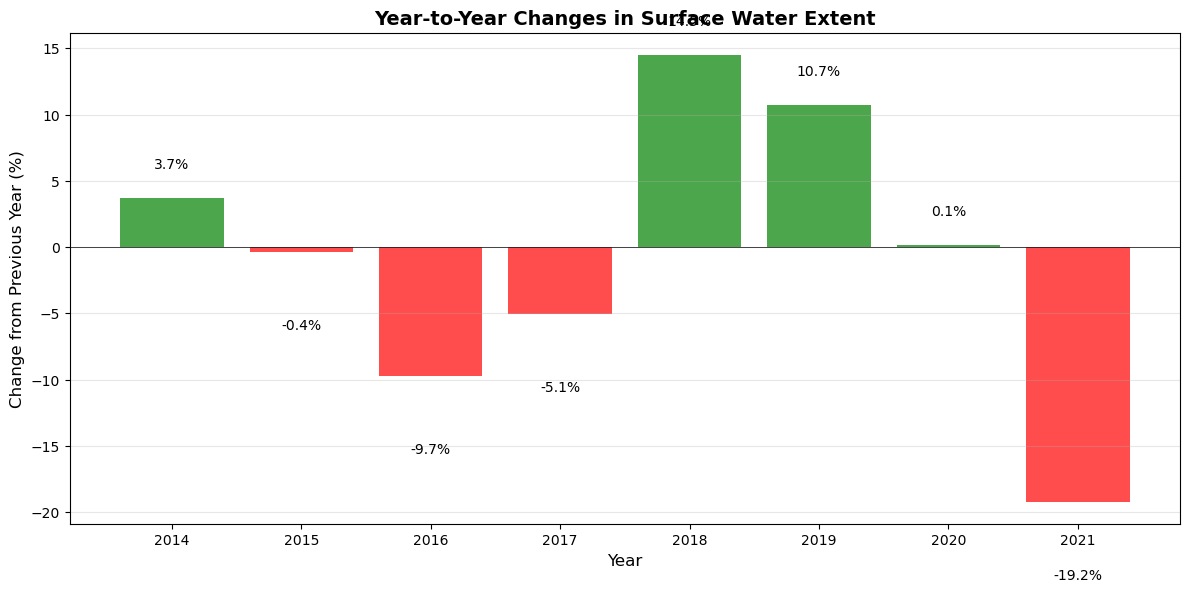


Largest increase: 2018 (+14.5%)
Largest decrease: 2021 (-19.2%)
Average annual variability: 7.9%


In [10]:
# Analyze year-to-year changes
changes = []
for i in range(1, len(stats_df)):
    prev_year = stats_df.iloc[i-1]
    curr_year = stats_df.iloc[i]
    
    change_km2 = curr_year['water_area_km2'] - prev_year['water_area_km2']
    change_pct = (change_km2 / prev_year['water_area_km2']) * 100
    
    changes.append({
        'year': curr_year['year'],
        'change_km2': change_km2,
        'change_pct': change_pct
    })

changes_df = pd.DataFrame(changes)

# Plot year-to-year changes
fig, ax = plt.subplots(figsize=(12, 6))

# Create bar plot with different colors for positive/negative changes
colors = ['green' if x > 0 else 'red' for x in changes_df['change_pct']]
bars = ax.bar(changes_df['year'], changes_df['change_pct'], color=colors, alpha=0.7)

# Add zero line
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Change from Previous Year (%)', fontsize=12)
ax.set_title('Year-to-Year Changes in Surface Water Extent', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, changes_df['change_pct']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (2 if height > 0 else -5),
            f'{val:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nLargest increase: {changes_df.loc[changes_df['change_pct'].idxmax(), 'year']} "
      f"(+{changes_df['change_pct'].max():.1f}%)")
print(f"Largest decrease: {changes_df.loc[changes_df['change_pct'].idxmin(), 'year']} "
      f"({changes_df['change_pct'].min():.1f}%)")
print(f"Average annual variability: {abs(changes_df['change_pct']).mean():.1f}%")

## Summary and Conclusions

In [ ]:
# Generate summary report
print("=== Black Hills Surface Water Summary (2013-2021) ===")
print(f"\nTemporal Patterns:")
print(f"- Period analyzed: {min(years)} to {max(years)} ({len(years)} years)")
print(f"- Average water extent: {stats_df['water_area_km2'].mean():.2f} km²")
print(f"- Maximum extent: {stats_df['water_area_km2'].max():.2f} km² ({stats_df.loc[stats_df['water_area_km2'].idxmax(), 'year']})")
print(f"- Minimum extent: {stats_df['water_area_km2'].min():.2f} km² ({stats_df.loc[stats_df['water_area_km2'].idxmin(), 'year']})")
print(f"- Range of variation: {stats_df['water_area_km2'].max() - stats_df['water_area_km2'].min():.2f} km²")

print(f"\nWater Persistence:")
if 'class_df' in locals() and len(class_df) > 0:
    for _, row in class_df.iterrows():
        print(f"- {row['Class']}: {row['Area (km²)']:.2f} km²")
else:
    print("- No persistent water features detected")

print(f"\nVariability:")
print(f"- Standard deviation: {stats_df['water_area_km2'].std():.2f} km²")
print(f"- Coefficient of variation: {(stats_df['water_area_km2'].std() / stats_df['water_area_km2'].mean()) * 100:.1f}%")
print(f"- Average year-to-year change: {abs(changes_df['change_pct']).mean():.1f}%")

# Simple trend analysis
slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(stats_df['year'], stats_df['water_area_km2'])
print(f"\nTrend Analysis:")
print(f"- Linear trend: {'Increasing' if slope > 0 else 'Decreasing'} ({slope:.3f} km²/year)")
print(f"- Trend significance: p-value = {p_value:.3f}")
print(f"- R-squared: {r_value**2:.3f}")